# add some tips

https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9



In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

def my_mnist_train_batch(size) :
    m = 500
    data = []
    for i in range(1000) :
        number = number = np.random.randint(5)
        image, label = mnist.train.next_batch(m)       
        for j in range(len(label)) : 
            
            if np.argmax(label[j])==number :
                data.append(image[j])
                number = number = np.random.randint(5)
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def my_mnist_test_batch(size, number = 0) :
    m = 500
    data = []
    for i in range(1000) :
        image, label = mnist.test.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

file_name = 'ex_anoGANs_3'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)
def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse) :
        
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid')
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def simple_D(x,isTrain=True,reuse = False) :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,28,28,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6)#1*1*1


    return r6
def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid')
    r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain),name = name)#256*16*16

 
        #conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same')
        #r4 = tf.nn.lrelu(tf.layers.batch_normalization(conv4,training=isTrain),0.2)#512*8*8


        #conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same')
        #r5 = tf.nn.lrelu(tf.layers.batch_normalization(conv5,training=isTrain),0.2)#1024*4*4


    return r3



Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
lr = 0.001

z_size = 100
ramda = 0.1


z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='u')
ano_y = tf.placeholder(tf.float32, shape = (1, 28,28,1),name='ano_y')

ano_z = tf.get_variable('ano_z', shape = [1, 1, 1, z_size], dtype = tf.float32, 
        initializer = tf.truncated_normal_initializer(mean= 0.0, stddev=0.1))

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 
soft_one = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_one') # 0.9~1.0
soft_zero = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_zero') # 0.0~0.1

G_z = simple_G(z,name='G_z')

D_real = simple_D(u,isTrain)
D_fake = simple_D(G_z,isTrain,reuse=True)


img_z = residual_loss_G(ano_z, name ='img_z')
img_z_result= simple_D(img_z,isTrain=False,reuse=True)

feature_y = feature_extractor_D(ano_y, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(img_z, reuse = True, name ='feature_z')


feature_loss = tf.reduce_mean(tf.abs(feature_y-feature_z),name = 'feature_loss')
D_real_loss = tf.reduce_mean(-(soft_one*tf.log(D_real + 1e-8) + (1-soft_one)*tf.log(1- D_real + 1e-8)),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-(soft_zero*tf.log(D_fake + 1e-8) + (1-soft_zero)*tf.log(1 - D_fake + 1e-8)),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')
residual_loss = tf.reduce_mean(tf.abs(img_z - ano_y), name = 'residual_loss')
#discrimination_loss = tf.reduce_mean(-tf.log(img_z_result + 1e-8),name = 'discrimination_loss')


mapping_loss = tf.add((1-ramda)*residual_loss, ramda*feature_loss,name = 'mapping_loss') 

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
ano_vars = [var for var in T_vars if var.name.startswith('ano')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    
mapping_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(mapping_loss, var_list=ano_vars, name='mapping_optim')



D_e : 2.646101, D_real_e : 1.390458, D_fake_e : 1.255643, G_e : 16.767776
D_e : 9.166995, D_real_e : 2.751991, D_fake_e : 6.480212, G_e : 9.600489
D_e : 6.557391, D_real_e : 2.061724, D_fake_e : 1.859966, G_e : 7.027040
D_e : 5.254876, D_real_e : 1.351932, D_fake_e : 1.284887, G_e : 5.474447
D_e : 4.535750, D_real_e : 1.213625, D_fake_e : 1.157560, G_e : 4.675671
D_e : 4.047741, D_real_e : 1.063876, D_fake_e : 1.026950, G_e : 4.156870
D_e : 3.725646, D_real_e : 1.087378, D_fake_e : 1.024569, G_e : 3.815478
D_e : 3.471066, D_real_e : 1.001168, D_fake_e : 0.939873, G_e : 3.572829
D_e : 3.279632, D_real_e : 0.991289, D_fake_e : 0.946392, G_e : 3.369103
D_e : 3.129984, D_real_e : 0.975282, D_fake_e : 0.956022, G_e : 3.200999
D_e : 3.009201, D_real_e : 0.978853, D_fake_e : 0.942093, G_e : 3.063857
D_e : 2.898388, D_real_e : 0.914574, D_fake_e : 0.874581, G_e : 2.944850
D_e : 2.803854, D_real_e : 0.900224, D_fake_e : 0.862802, G_e : 2.840727
D_e : 2.723940, D_real_e : 0.897847, D_fake_e : 0.

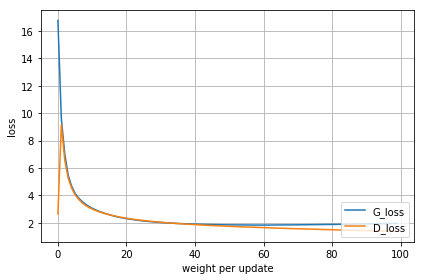

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,z_size))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(10000) :
        
        train_images = my_mnist_train_batch(100) 
        u_ = np.reshape(train_images,(-1,28,28,1)) 
        z_ = np.random.normal(0,1,size=(100,1,1,z_size))
        soft_one_ = np.random.uniform(0.9,1.0,(100,1,1,1))
        soft_zero_ = np.random.uniform(0.0,0.1,(100,1,1,1))
        
        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True,
                                                                                         soft_one : soft_one_, soft_zero : soft_zero_})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,784)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [6]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")





INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


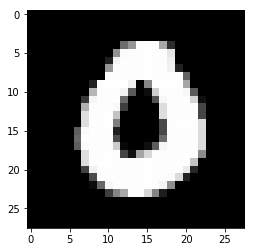

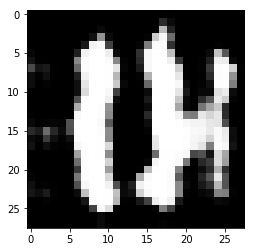

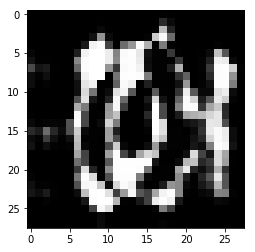

11.1125 0.21388
0.21388 3.2229
0.0845401 0.27183
0.0409172 0.136939
0.0327801 0.128986
0.0293575 0.124109
0.0272375 0.120467
0.0260102 0.126561
0.0250867 0.129862
0.0245464 0.131297
0.0239371 0.130943


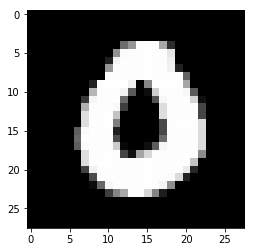

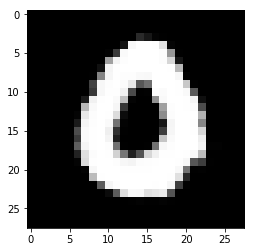

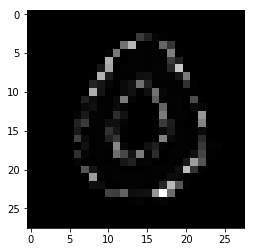

2.59335 0.0234797


In [7]:
im = my_mnist_test_batch(1, number = 0) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [8]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


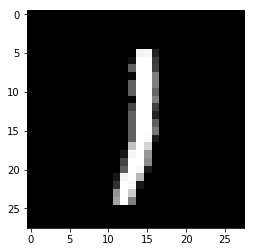

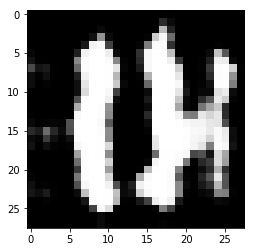

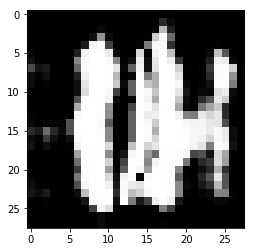

13.866 0.331206
0.331206 3.22289
0.194047 1.53578
0.131273 1.57424
0.105318 1.10696
0.0294231 0.65601
0.0207044 0.647637
0.015444 0.658972
0.0136809 0.678367
0.0127842 0.680889
0.0117429 0.661922


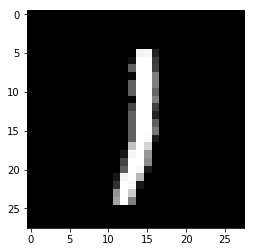

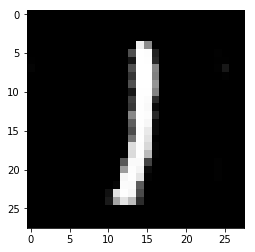

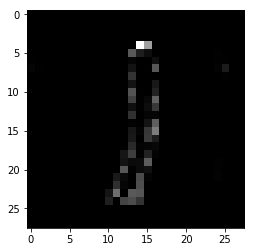

1.3595 0.0109701


In [9]:
im = my_mnist_test_batch(1, number = 1) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [10]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


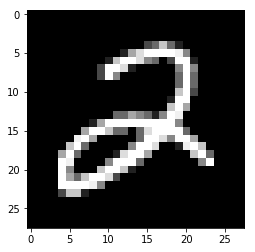

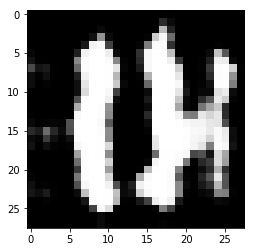

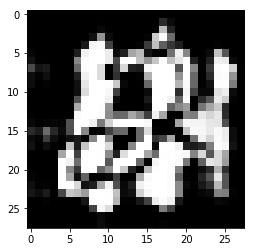

14.7627 0.299692
0.299692 3.2229
0.265581 1.66056
0.190488 0.967523
0.155582 2.16256
0.144133 2.50608
0.12955 2.25253
0.0669253 2.6654
0.0565292 2.50882
0.0530432 2.32082
0.0515689 2.2464


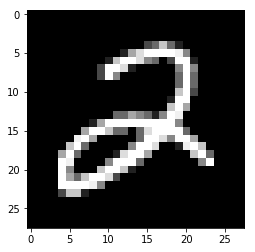

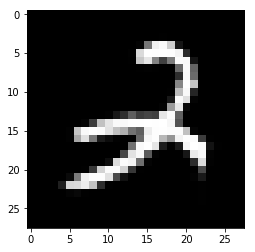

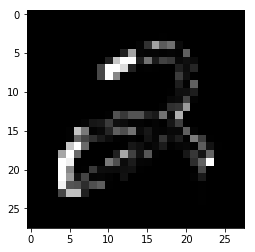

5.70579 0.0504724


In [11]:
im = my_mnist_test_batch(1, number = 2) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [12]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


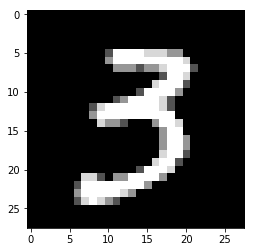

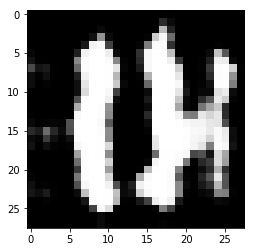

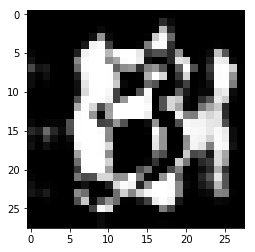

13.6655 0.253291
0.253291 3.2229
0.0879922 0.752738
0.0462649 1.31843
0.0325833 1.53575
0.0258382 1.64081
0.0248479 1.66647
0.0244126 1.72433
0.0239712 1.79468
0.0236526 1.86788
0.0238106 1.938


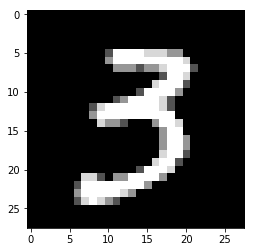

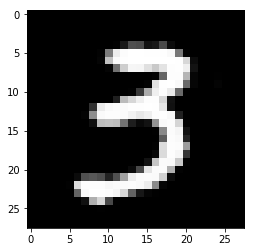

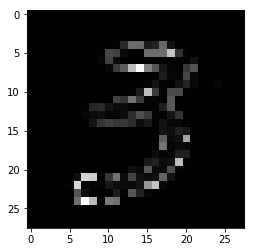

2.56593 0.0236183


In [13]:
im = my_mnist_test_batch(1, number = 3) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [14]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


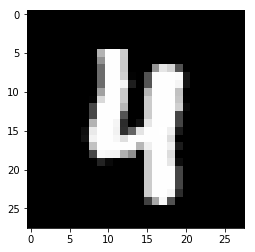

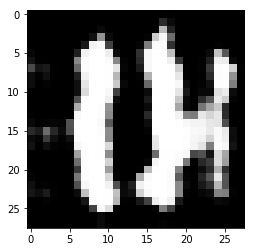

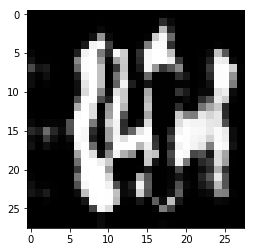

12.427 0.233793
0.233793 3.22289
0.141684 1.32407
0.0892379 0.494527
0.0646173 0.412037
0.0560612 0.334581
0.0532258 0.328263
0.0488119 0.258166
0.0402296 0.222833
0.0365211 0.263084
0.0336248 0.283915


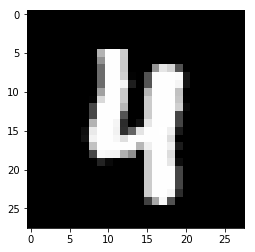

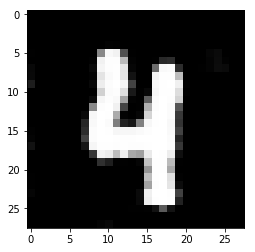

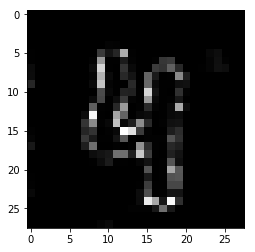

3.48301 0.0299288


In [15]:
im = my_mnist_test_batch(1, number = 4) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [16]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


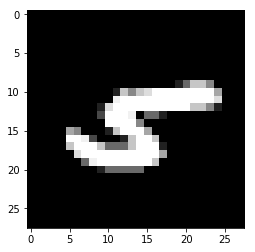

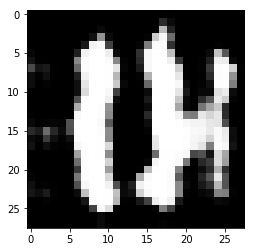

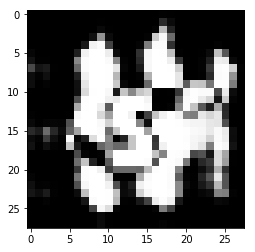

16.5616 0.325844
0.325844 3.22289
0.214509 3.14809
0.149571 1.48623
0.126468 0.580448
0.122294 0.473686
0.119363 0.225241
0.116897 0.229012
0.115748 0.299882
0.115912 0.404212
0.115881 0.536636


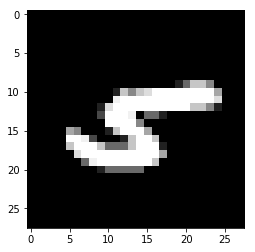

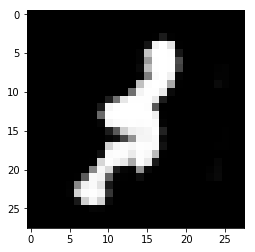

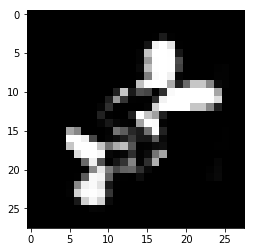

8.85788 0.113871


In [17]:
im = my_mnist_test_batch(1, number = 5) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [18]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


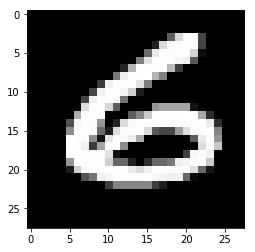

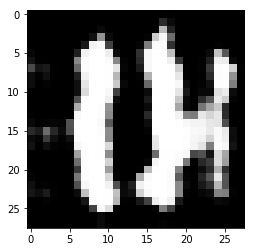

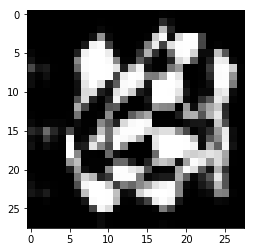

14.3832 0.260415
0.260415 3.22289
0.244467 2.38045
0.218071 2.39958
0.186449 2.10844
0.133324 1.05949
0.128285 0.794666
0.12323 1.00769
0.11891 1.07669
0.104121 0.131409
0.0904648 0.188638


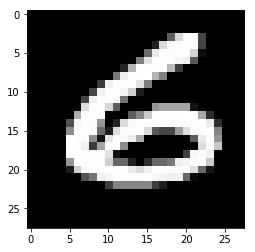

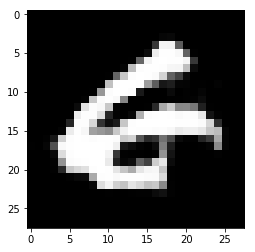

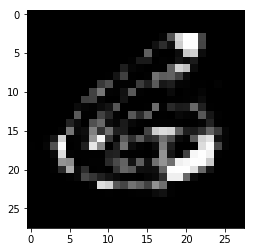

5.97728 0.0793255


In [19]:
im = my_mnist_test_batch(1, number = 6) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [3]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


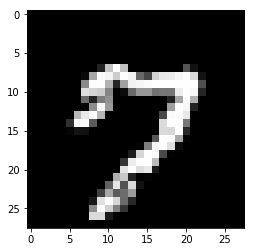

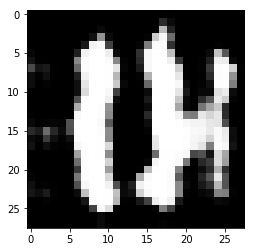

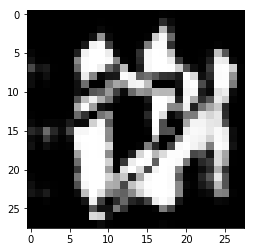

13.8411 0.269186
0.269186 13.8411
0.181927 11.1016
0.142437 10.1847
0.127428 9.75436
0.121677 9.35224
0.118853 9.11685
0.117178 8.94129
0.116004 8.82388
0.114295 8.73652
0.110601 8.62955


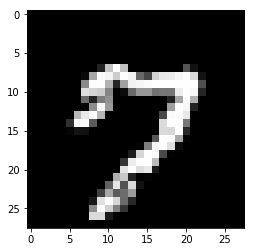

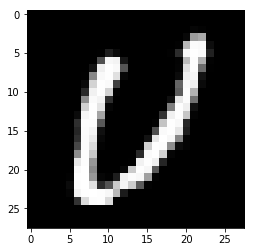

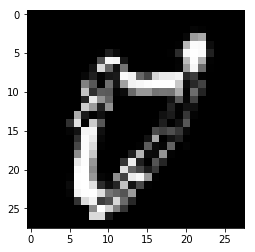

8.53457 0.10811


In [4]:
im = my_mnist_test_batch(1, number = 7) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [5]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


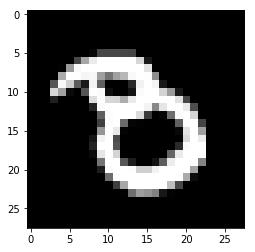

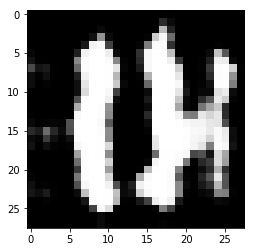

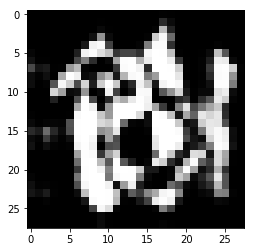

14.5205 0.27756
0.27756 14.5205
0.172046 10.1419
0.131435 8.73981
0.109077 7.76844
0.0943723 7.28012
0.0804062 6.72544
0.0731969 6.301
0.0682908 5.94231
0.0629979 5.65916
0.058356 5.37168


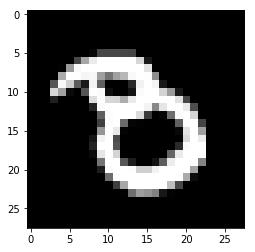

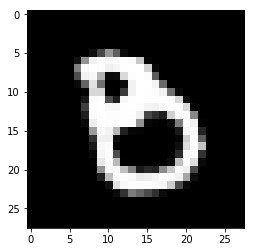

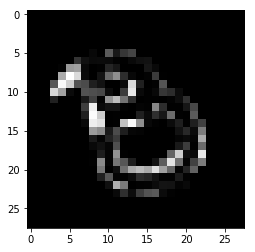

5.18416 0.0549861


In [6]:
im = my_mnist_test_batch(1, number = 8) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [7]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_3/para.cktp


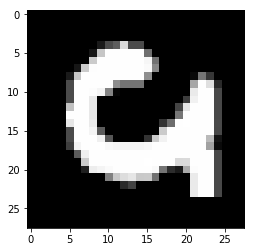

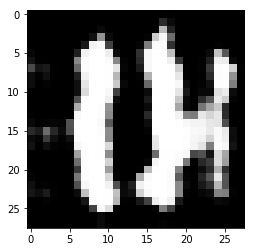

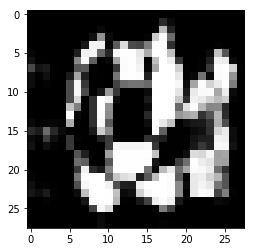

12.8627 0.260421
0.260421 12.8627
0.219349 11.3932
0.189922 11.0696
0.143861 9.46008
0.104705 7.35855
0.0975794 6.96464
0.0871721 6.34887
0.0791452 5.83727
0.074194 5.36111
0.0716253 5.04705


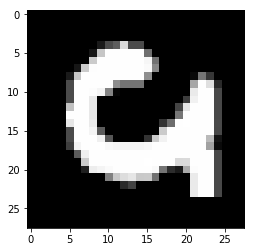

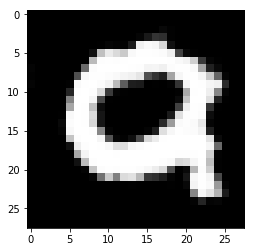

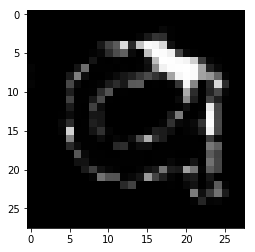

4.8394 0.069772


In [8]:
im = my_mnist_test_batch(1, number = 9) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,feature_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)